# Importing libraries

In [22]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
import numpy as np
import qiskit
import copy
import matplotlib.pyplot as plt
np.random.seed(42)

# Importing the Iris Dataset


In [23]:
iris = datasets.load_iris()
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

# Hyperparameters

In [24]:
N = 4

# Designing the circuit

In [25]:
def feature_map(X, encoding_type):
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    if encoding_type == 'rx':
        for i, x in enumerate(X):
            qc.rx(x, i)
    elif encoding_type == 'ry':
        for i, x in enumerate(X):
            qc.ry(x, i)
    elif encoding_type == 'rz':
        for i, x in enumerate(X):
            qc.rz(x, i)    
    return qc, c

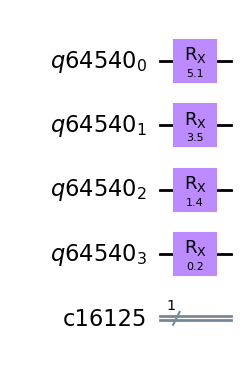

In [26]:
# feature map test
qc,c = feature_map(X[0], 'rx')
qc.draw('mpl')

# Using entanglment and parameteristaion

In [27]:
def variational_circuit(qc, theta, rotation_type):
    
    for i in range(N-1):
        qc.cnot(i, i+1)
    qc.cnot(N-1, 0)
    
    if rotation_type == 'rx':
        for i in range(N):
            qc.rx(theta[i], i)
    elif rotation_type == 'ry':
        for i in range(N):
            qc.ry(theta[i], i)
    elif rotation_type == 'rz':
        for i in range(N):
            qc.rz(theta[i], i)
            
    return qc

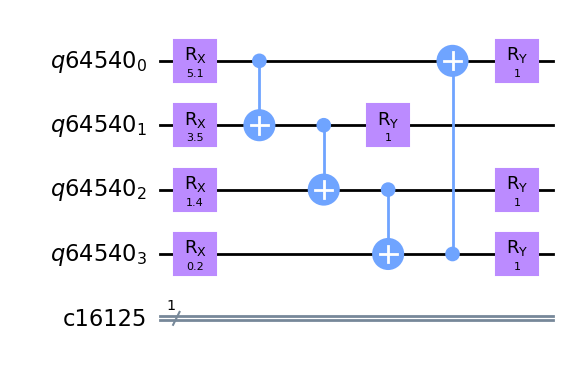

In [28]:
qc = variational_circuit(qc, np.ones(4), 'ry')
qc.draw('mpl')

# Defining the algorithm

In [29]:
def quantum_nn(X, theta, shots, encoding_type, rotation_type, simulator=True):
    
    qc, c = feature_map(X, encoding_type)
    qc = variational_circuit(qc, theta, rotation_type)
    qc.measure(0, c)

    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibm_oslo')
        
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return counts['1']/shots


In [31]:
qc, c = feature_map(X[0], 'rz')
qc = variational_circuit(qc, np.ones(4), 'rz')
qc.measure(0, c)
backend = Aer.get_backend('qasm_simulator')
    
job = qiskit.execute(qc, backend, shots=5000)
result = job.result()
counts = result.get_counts(qc)
print(counts)

{'0': 5000}


In [33]:
# quantum_nn test
quantum_nn(X[0], np.ones(4), 5000, 'rx', 'ry')

0.5402

# Defining the loss function

In [34]:
def loss(prediction, target):
    return(prediction-target)**2

In [35]:
# loss test
loss(quantum_nn(X[0], [0.9, 0.9, 0.9, 0.9], 5000, 'rx', 'ry'), Y[0])

0.29986576

# Defining the gradient function (gradient descent)

In [36]:
def gradient(X, Y, theta, delta, shots, encoding_type, rotation_type):

    grad = []
    for i in range(len(theta)):
        
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        prediction_1 = quantum_nn(X, dtheta, shots, encoding_type, rotation_type)
        prediction_2 = quantum_nn(X, theta, shots, encoding_type, rotation_type)
        
        grad.append((loss(prediction_1, Y) - loss(prediction_2, Y)) / delta)
        
    return np.array(grad)

In [37]:
gradient(X[0], Y[0], np.ones(4), 0.01, 5000, 'rx', 'ry')

array([ 0.170624, -0.57726 , -0.856908,  0.518592])

# Defining Accuracy function

In [38]:
def accuracy(X, Y, theta, shots, encoding_type, rotation_type):
    
    counter = 0
    for X_i, Y_i, in zip(X, Y):
        prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [39]:
# Accuracy test
accuracy(X_test, Y_test, [-1.5, 1.2, 0.6, -0.2], 1000, 'rx', 'ry')

0.45454545454545453

In [40]:
def get_best_weight(accuracies, weights):
    return(weights[accuracies.index(max(accuracies))])

# Training

# Test 1

In [41]:

N = 4
def model(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    if optimizing_weights==True:
        acc = accuracy(x_test, y_test, get_best_weight(acc_list, weights_list), shots, encoding_type=encoding_gate, rotation_type=rotation_gate)
        return acc, get_best_weight(acc_list, weights_list), theta, loss_list, acc_list, weights_list
    else:
        acc = accuracy(x_test, y_test, theta, shots, encoding_type=encoding_gate, rotation_type=rotation_gate)
        return acc, theta, loss_list, acc_list, weights_list

In [19]:
gates = ['rx', 'ry', 'rz']
results = {}
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            print(f'Circuit type : {circuit_type} -> encoding : {encoding_gate} rotation : {rotation_gate}')
            acc, theta, loss_list, acc_list, weights_history = model(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type=encoding_gate, rotation_type=rotation_gate, delta=0.01)
            results.update({circuit_type: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
            print(f" {circuit_type} accuracy : {results.get(circuit_type).get('accuracy')}")

Circuit type : rx-rx -> encoding : rx rotation : rx
Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.278 	 0.194 	 [1.296908  0.6750618 0.9607566 0.8587086] 	 1
1 	 0.256 	 0.776 	 [2.0027024 0.5443888 0.9405888 0.5910978] 	 2
2 	 0.22 	 0.851 	 [2.3995886 0.6509628 0.819336  0.90772  ] 	 3
3 	 0.213 	 0.851 	 [2.3605978 0.5971512 0.7448906 0.8155768] 	 4
4 	 0.206 	 0.836 	 [2.7174796 0.4205694 0.6522408 1.4732924] 	 5
5 	 0.204 	 0.836 	 [2.4270228 0.5787034 0.6829584 1.4042626] 	 6
6 	 0.212 	 0.836 	 [2.425195  0.412776  0.5446668 1.5457014] 	 7
7 	 0.206 	 0.836 	 [ 2.7369978 -0.0636868  0.4048374  1.9536586] 	 8
8 	 0.203 	 0.776 	 [ 2.8054106 -0.1650312  0.6071584  1.5648892] 	 9
9 	 0.206 	 0.836 	 [ 2.6147694 -0.4667168  0.794793   1.5924418] 	 10
 rx-rx accuracy : 0.7575757575757576
Circuit type : rx-ry -> encoding : rx rotation : ry
Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.283 	 0.149 	 [1.0023088 0.7199056 0.7296962 0.9349564] 	 1
1 	 0.265 	 0.209 	 [1.4140592 0.397890

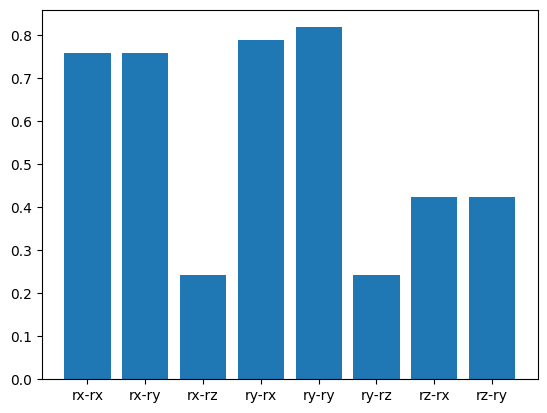

In [20]:
gates = ['rx', 'ry', 'rz']
labels = []
accuracies = []
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            labels.append(circuit_type)
            accuracies.append(results.get(circuit_type).get('accuracy'))
            
plt.bar(labels, accuracies)
plt.show()

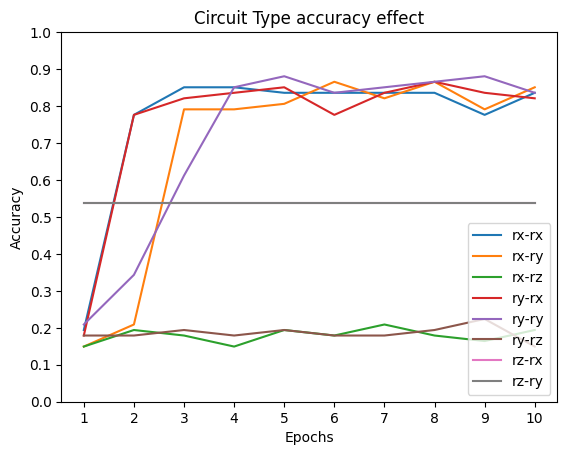

In [21]:
gates = ['rx', 'ry', 'rz']
labels = []
accuracies = []
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            plt.plot([x for x in range(1, 11)], results.get(circuit_type).get('acc_list'), label=circuit_type)
            
plt.xticks([x for x in range(1, 11)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Circuit Type accuracy effect')
plt.legend()
plt.show()

In [42]:

N = 4
def model_1(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []
    loss_val = 1
    i = 0
    print('Epoch \t Loss \t Training Accuracy \t theta')

    while loss_val > 0.17:
        
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta
        loss_val = np.mean(loss_tmp)
        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
        i = i + 1
    
    return theta, loss_list, acc_list, weights_list

In [23]:
theta_b, loss_list_b, acc_list_b, weights_history_b = model_1(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=20, theta=np.ones(N), shots=5000, encoding_type='ry', rotation_type='ry', delta=0.01)

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.378 	 0.149 	 [0.5971522 1.1518514 1.1122332 0.9548948] 	 1
1 	 0.357 	 0.104 	 [0.7145474 0.5814126 1.5299672 1.4414378] 	 2
2 	 0.376 	 0.164 	 [0.6513536 0.6939756 1.9279442 1.2060362] 	 3
3 	 0.364 	 0.149 	 [0.3714456 0.7807714 1.8799676 1.6519024] 	 4
4 	 0.306 	 0.388 	 [-0.3885272  0.5125164  1.762522   1.5119076] 	 5
5 	 0.256 	 0.567 	 [-0.731856   0.2750924  1.7415078  1.5944418] 	 6
6 	 0.209 	 0.701 	 [-1.3130752  0.4326744  2.1135106  1.4071598] 	 7
7 	 0.188 	 0.761 	 [-1.7129626  0.7123072  1.7395294  1.580425 ] 	 8
8 	 0.172 	 0.851 	 [-2.291085   1.1096038  1.7899466  1.6459798] 	 9
9 	 0.17 	 0.836 	 [-2.213219   0.9490758  1.3923496  1.868661 ] 	 10
10 	 0.168 	 0.836 	 [-2.2570162  0.9574626  1.3964586  2.1239208] 	 11


In [19]:

N = 4
def model_2(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    return theta, loss_list, acc_list, weights_list

In [25]:
for learning_rate in [0.001, 0.01, 0.05, 0.1]:
    theta, loss_list, acc_list, weights_history = model_2(X_train, Y_train, X_test, Y_test, learning_rate=learning_rate, epochs=20, theta=np.ones(N), shots=5000, encoding_type='ry', rotation_type='ry', delta=0.01)
    acc = accuracy(X_test, Y_test, theta, 5000, encoding_type='ry', rotation_type='ry')
    results.update({learning_rate: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
    print(f" Learning rate : {learning_rate} accuracy : {results.get(learning_rate).get('accuracy')}")

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.383 	 0.164 	 [1.00110523 0.99399281 1.01170373 0.99742368] 	 1
1 	 0.385 	 0.164 	 [0.99618165 1.00113756 1.00816821 0.99012081] 	 2
2 	 0.383 	 0.134 	 [0.98683728 1.00402302 1.01563256 0.98372811] 	 3
3 	 0.385 	 0.149 	 [0.97851785 1.00273488 1.01362772 0.97704994] 	 4
4 	 0.382 	 0.164 	 [0.97395884 0.99856432 1.02304451 0.98866172] 	 5
5 	 0.386 	 0.179 	 [0.9700828  0.98742676 1.02769029 0.98355549] 	 6
6 	 0.383 	 0.134 	 [0.98374295 0.9842073  1.02223418 0.99045988] 	 7
7 	 0.385 	 0.164 	 [0.98456893 0.9930016  1.02144075 0.98530657] 	 8
8 	 0.382 	 0.119 	 [0.98745295 1.00011352 1.03068645 0.98090686] 	 9
9 	 0.383 	 0.134 	 [0.99167907 0.99641146 1.04864378 0.97259144] 	 10
10 	 0.385 	 0.149 	 [1.00215101 0.98314914 1.04709665 0.9649771 ] 	 11
11 	 0.383 	 0.149 	 [0.9967269  0.99918185 1.04839714 0.97737847] 	 12
12 	 0.384 	 0.164 	 [1.00245642 0.99347943 1.04522868 0.97312808] 	 13
13 	 0.384 	 0.119 	 [1.00418134 0.9988165

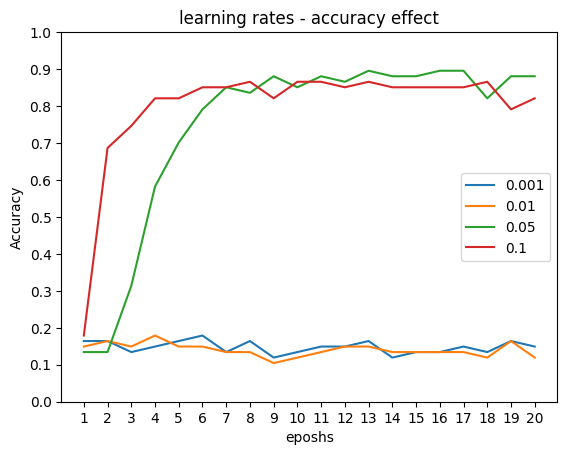

In [27]:
for learning_rate in [0.001, 0.01, 0.05, 0.1]:
    plt.plot([x for x in range(1, 21)], results.get(learning_rate).get('acc_list'), label=learning_rate)
            
plt.xticks([x for x in range(1, 21)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('eposhs')
plt.ylabel('Accuracy')
plt.title('learning rates - accuracy effect')
plt.legend()
plt.show()

In [71]:
n_shots_results = {}
for n_shots in [1000, 5000, 10000, 50000]:
    theta, loss_list, acc_list, weights_history = model_2(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=20, theta=np.ones(N), shots=n_shots, encoding_type='ry', rotation_type='ry', delta=0.01)
    acc = accuracy(X_test, Y_test, theta, n_shots, encoding_type='ry', rotation_type='ry')
    n_shots_results.update({n_shots: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
    print(f" Number of Shots : {n_shots} accuracy : {n_shots_results.get(n_shots).get('accuracy')}")

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.295 	 0.672 	 [-0.977325  0.909615  1.175165  1.032875] 	 1
1 	 0.186 	 0.836 	 [-2.424325  0.793585  1.076965  0.912925] 	 2
2 	 0.172 	 0.851 	 [-2.20896   0.144745  2.33575   1.10386 ] 	 3
3 	 0.178 	 0.761 	 [-1.55546  -0.381255  2.55754   0.560785] 	 4
4 	 0.176 	 0.851 	 [-2.490475 -0.456375  2.379895  0.953955] 	 5
5 	 0.18 	 0.851 	 [-2.67623  -0.301315  2.06635   1.12139 ] 	 6
6 	 0.18 	 0.866 	 [-2.899125 -0.42772   2.806575  0.206115] 	 7
7 	 0.176 	 0.836 	 [-2.356585 -0.04863   3.30145  -0.066135] 	 8
8 	 0.169 	 0.821 	 [-2.12991  -0.349545  3.877705  0.595825] 	 9
9 	 0.171 	 0.836 	 [-1.93621   0.260705  3.66896   0.565125] 	 10
10 	 0.176 	 0.791 	 [-2.715005  0.19641   3.719125  1.00587 ] 	 11
11 	 0.173 	 0.836 	 [-2.751315 -0.77679   4.023735  1.33208 ] 	 12
12 	 0.19 	 0.716 	 [-3.310325 -1.889345  4.97541   1.36814 ] 	 13
13 	 0.201 	 0.806 	 [-3.228245 -2.479675  5.58534   1.470165] 	 14
14 	 0.196 	 0.836 	 [-2.9262

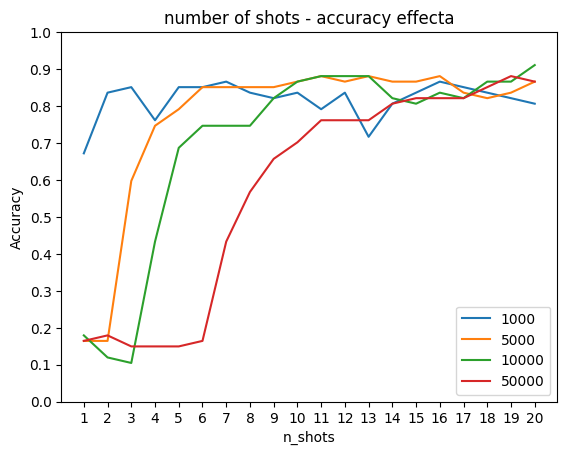

In [73]:
shots_list = [1000, 5000, 10000, 50000]
for n_shots in shots_list:
    plt.plot([x for x in range(1, 21)], n_shots_results.get(n_shots).get('acc_list'), label=n_shots)
            
plt.xticks([x for x in range(1, 21)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('n_shots')
plt.ylabel('Accuracy')
plt.title('number of shots - accuracy effecta')
plt.legend()
plt.show()

In [44]:
delta_results = {}
for delta in [0.01, 0.05, 0.1, 1]:
    theta, loss_list, acc_list, weights_history = model_2(X_train, Y_train, X_test, Y_test, learning_rate=0.1, epochs=20, theta=np.ones(N), shots=1000, encoding_type='ry', rotation_type='ry', delta=delta)
    acc = accuracy(X_test, Y_test, theta, 1000, encoding_type='ry', rotation_type='ry')
    delta_results.update({delta: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
    print(f" Delta : {delta} accuracy : {delta_results.get(delta).get('accuracy')}")

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.226 	 0.821 	 [ 4.08079  1.93397 -0.21944  1.22532] 	 1
1 	 0.18 	 0.701 	 [5.07223 1.90144 1.16446 1.37678] 	 2
2 	 0.179 	 0.791 	 [4.78119 1.56755 2.3768  1.59928] 	 3
3 	 0.178 	 0.881 	 [3.96861 1.06164 1.80997 1.94197] 	 4
4 	 0.172 	 0.806 	 [3.87579 3.4055  2.84769 1.16958] 	 5
5 	 0.177 	 0.776 	 [4.54045 5.33041 2.583   3.28134] 	 6
6 	 0.172 	 0.806 	 [4.30012 4.22917 1.2927  2.63353] 	 7
7 	 0.178 	 0.776 	 [4.67028 3.99358 0.64139 2.46528] 	 8
8 	 0.18 	 0.806 	 [4.17863 4.11572 1.38055 1.94307] 	 9
9 	 0.171 	 0.881 	 [4.02503 4.63038 0.65196 3.43946] 	 10
10 	 0.18 	 0.836 	 [3.9899  4.24349 1.78965 5.23642] 	 11
11 	 0.185 	 0.836 	 [3.87895 6.24932 3.50338 5.2552 ] 	 12
12 	 0.174 	 0.806 	 [4.38276 6.03263 2.89356 7.25749] 	 13
13 	 0.169 	 0.851 	 [4.05825 6.43675 2.43888 5.89771] 	 14
14 	 0.175 	 0.881 	 [3.91074 6.39082 3.2395  7.28319] 	 15
15 	 0.173 	 0.866 	 [3.89107 4.92533 1.70787 8.24454] 	 16
16 	 0.179 	 0.88

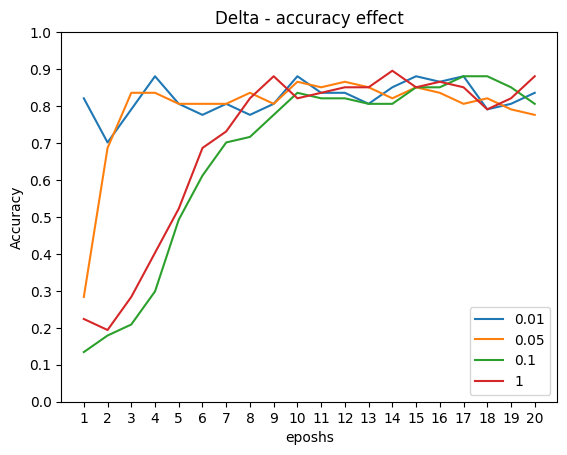

In [45]:
for delta in [0.01, 0.05, 0.1, 1]:
    plt.plot([x for x in range(1, 21)], delta_results.get(delta).get('acc_list'), label=delta)
            
plt.xticks([x for x in range(1, 21)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('eposhs')
plt.ylabel('Accuracy')
plt.title('Delta - accuracy effect')
plt.legend()
plt.show()

In [46]:
def feature_map_2(X, theta):
    n = 4

    qr = QuantumRegister(4)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(qr,c )
    for i, x in enumerate(X):
        qc.ry(x, i)
    for i in range(n-1):
        qc.cx(i, i+1)

    qc.barrier()
    for i in range(4):
        qc.rz(theta[i], i)
    qc.barrier()

    for i in reversed(range(n-1)):
        qc.cx(i, i+1)
    qc.h(0)

    return qc, c

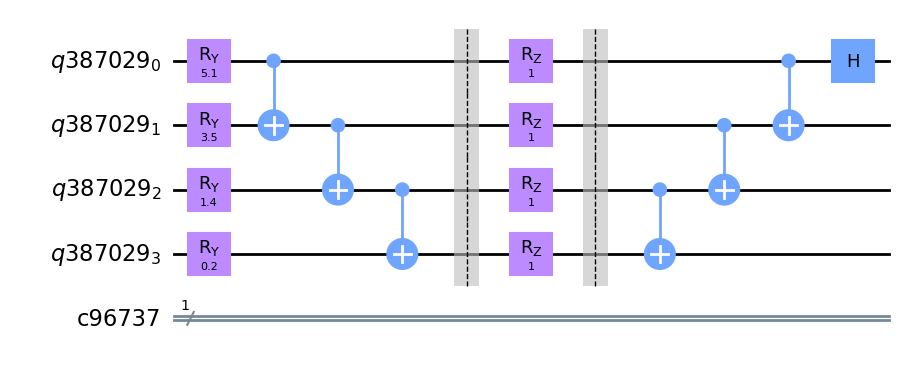

In [47]:
qc, c = feature_map_2(X[0], np.ones(4))
qc.draw('mpl')

In [84]:
def quantum_nn(X, theta, shots, encoding_type=None, rotation_type=None, simulator=True):
    
    qc, c = feature_map_2(X, theta)
    qc.measure(0, c)

    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibm_oslo')
        
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return counts['1']/shots

0.8892 -6
0.1366 -5
0.4406 -4
0.9426 -3
0.2352 -2
0.3158 -1
0.9654 0
0.321 1
0.2308 2
0.9408 3
0.432 4
0.1504 5
0.8812 6


In [93]:
def accuracy(X, Y, theta, shots):
    
    counter = 0
    for X_i, Y_i, in zip(X, Y):
        prediction = quantum_nn(X_i, theta, shots)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [94]:
def gradient(X, Y, theta, delta, shots):

    grad = []
    for i in range(len(theta)):
        
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        prediction_1 = quantum_nn(X, dtheta, shots)
        prediction_2 = quantum_nn(X, theta, shots)
        
        grad.append((loss(prediction_1, Y) - loss(prediction_2, Y)) / delta)
        
    return np.array(grad)

In [95]:
N = 4
def model_5(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots)

            if loss(quantum_nn(X_i, new_theta, shots), Y_i) < loss(quantum_nn(X_i, theta, shots), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    return theta, loss_list, acc_list, weights_list

In [100]:
theta, loss_list, acc_list, weights_list = model_5(X_train, Y_train, X_test, Y_test, 0.01, 30, [1, 1, 1, 1], 5000, 0.01)

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.182 	 0.836 	 [0.89819408 1.084498   0.95411588 0.92660584] 	 1
1 	 0.176 	 0.821 	 [0.94561884 1.06274228 1.1072818  0.9913924 ] 	 2
2 	 0.167 	 0.821 	 [0.92717316 1.1019936  1.09171028 0.983799  ] 	 3
3 	 0.168 	 0.821 	 [0.96379468 1.09413012 1.09879456 0.94599768] 	 4
4 	 0.171 	 0.821 	 [0.9933912  1.17291292 1.08685428 0.95954772] 	 5
5 	 0.174 	 0.836 	 [0.98290064 1.19426392 1.08446056 0.948375  ] 	 6
6 	 0.171 	 0.836 	 [0.96130752 1.26282004 0.99004748 0.94417444] 	 7
7 	 0.174 	 0.851 	 [0.98639172 1.2631586  1.07508328 0.9622004 ] 	 8
8 	 0.169 	 0.881 	 [0.94373488 1.38395336 1.03020588 0.98066956] 	 9
9 	 0.165 	 0.851 	 [0.93000604 1.41859536 1.05900316 0.9615424 ] 	 10
10 	 0.166 	 0.851 	 [0.98468684 1.4065506  1.08545656 0.96679048] 	 11
11 	 0.166 	 0.866 	 [1.037757   1.40858832 1.05411036 0.97446412] 	 12
12 	 0.164 	 0.881 	 [0.96827192 1.39314908 1.16045332 0.97353612] 	 13
13 	 0.159 	 0.836 	 [0.92725816 1.4243712

In [101]:
accuracy(X_test, Y_test, theta, 5000)

0.9090909090909091

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


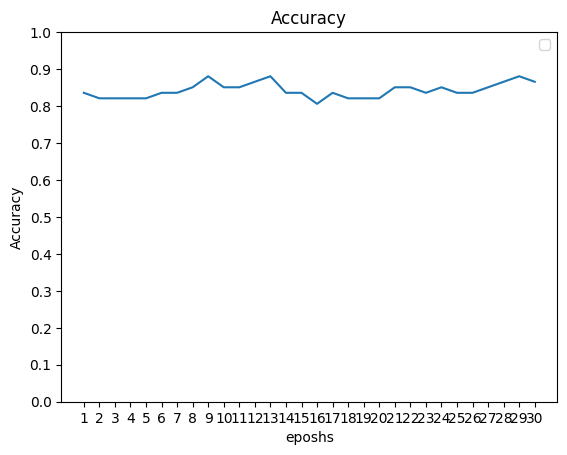

In [102]:
plt.plot([x for x in range(1, 31)], acc_list)
            
plt.xticks([x for x in range(1, 31)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('eposhs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

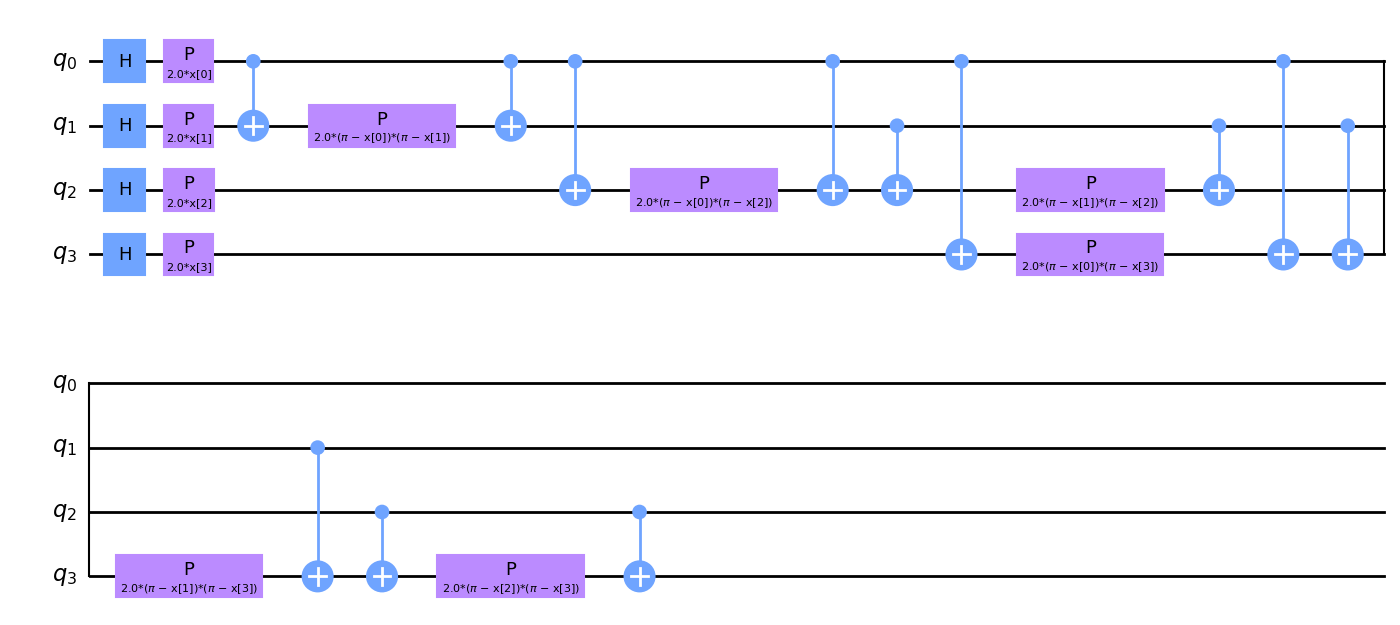

In [103]:
from qiskit.circuit.library import ZZFeatureMap

num_features = X_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

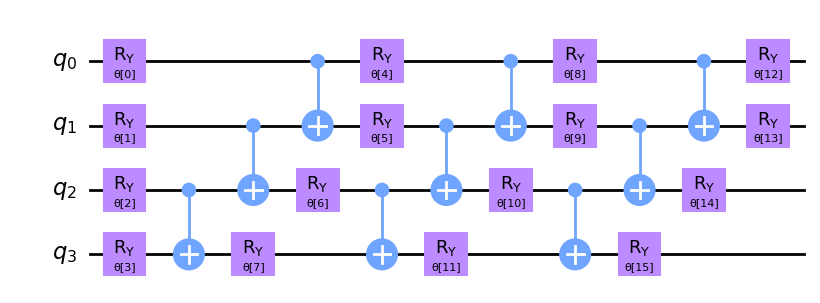

In [104]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [105]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [106]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [107]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

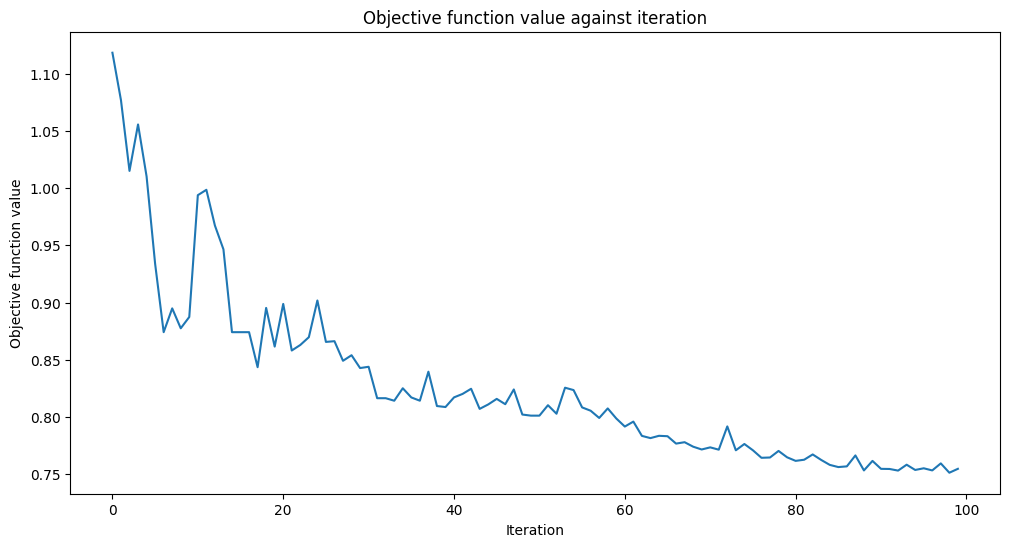

Training time: 121 seconds


In [109]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, Y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [117]:
train_score_q4 = vqc.score(X_train, Y_train)
test_score_q4 = vqc.score(X_test, Y_test)


print(f"Quantum QNN on the training dataset: {accuracy(X_train, Y_train, theta, 5000):.2f}")
print(f"Quantum QNN on the test dataset:     {accuracy(X_test, Y_test, theta, 5000):.2f}")
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum QNN on the training dataset: 0.88
Quantum QNN on the test dataset:     0.94
Quantum VQC on the training dataset: 0.82
Quantum VQC on the test dataset:     0.82
